In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"  # In case MKL is used instead of OpenBLAS
import sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import requests
import lzma
import shutil
from tqdm.notebook import tqdm

# 1.1 Import Metrics

In [2]:
sys.path.append("../")
# Import the metrics function
from metric.evaluator import train_evaluator
from metric.pca import *
from metric.fst import *
from metric.umap import *
from metric.precision_recall import *
from metric.correlation_score import *
from metric.aats import *
from metric.basic_sanity_check import *
from metric.allele_freq import *
from metric.geno_freq import *
from metric.LD import *
from metric.GWAS import *

2025-07-31 09:03:16.058470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 09:03:16.058558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 09:03:16.058611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 09:03:16.068341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 09:03:17.076323: W tensorflow/compiler/

# 1.2 Import Trained Models

In [3]:
def download_model(url, output_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1048576  # 1 MB
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

    with open(output_path, 'wb') as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)

    progress_bar.close()
    if total_size != 0 and progress_bar.n != total_size:
        print("WARNING: Download size mismatch.")
    else:
        print("Download completed:", output_path)

## Import and Load trained WGAN+GS

In [4]:
sys.path.append("../models/WGAN_GS/cows/ALL")
## WGAN+GS for Cow ALL CHRs
from wgan_model import WGAN_GP
# Load Configuration
from wgan_cow_all_configs import (CONFIG_WGAN_COW_ALL,device_wgan)# You may need to adjust the device configuration based on your available CPU or GPU

In [5]:
# Create Model
wgan = WGAN_GP(CONFIG_WGAN_COW_ALL, device_wgan)

In [6]:
# Download Model
url = "https://zenodo.org/record/16411670/files/wgan_cow_all.pth.xz?download=1" # Zenodo url for trained model
download_model(url, "wgan_cow_all.pth.xz")
# Extract the .xz file
with lzma.open("wgan_cow_all.pth.xz") as compressed:
    with open("wgan_cow_all.pth", "wb") as out_file:
        shutil.copyfileobj(compressed, out_file)

  0%|          | 0.00/2.40G [00:00<?, ?iB/s]

Download completed: wgan_cow_all.pth.xz


In [7]:
# Load Model
wgan.G.load_state_dict(torch.load("wgan_cow_all.pth"))

<All keys matched successfully>

## Import and Load trained PCA+DM

In [8]:
# Import Trained Models
sys.path.append("../models/PCA_DM/cows/ALL")
## DM for Cow ALL CHRs
from dm_model import GaussianDiffusion, TimeSampler, NoisePredictor, DDPM
# Load Configuration
from dm_cow_all_configs import (CONFIG_DM_COW_ALL,device_dm) # You may need to adjust the device configuration based on your available CPU or GPU

In [9]:
diffusion_process = GaussianDiffusion(num_diffusion_timesteps=CONFIG_DM_COW_ALL["num_timesteps"], device = device_dm)
time_sampler = TimeSampler(diffusion_process.tmin, diffusion_process.tmax)
noise_predictor = NoisePredictor(CONFIG_DM_COW_ALL["snp_dim"],CONFIG_DM_COW_ALL["time_embedding_dim"],CONFIG_DM_COW_ALL["label_embedding_dim"],CONFIG_DM_COW_ALL["hidden_dim_1"],CONFIG_DM_COW_ALL["hidden_dim_2"],CONFIG_DM_COW_ALL["hidden_dim_3"],CONFIG_DM_COW_ALL["num_timesteps"]).to(device_dm)
dm = DDPM(CONFIG_DM_COW_ALL["snp_dim"], diffusion_process, time_sampler, noise_predictor).to(device_dm)

In [10]:
# Download Model
url = "https://zenodo.org/record/16571171/files/dm_cow_all.pth?download=1" # Zenodo url for trained model
download_model(url, "dm_cow_all.pth")

  0%|          | 0.00/866M [00:00<?, ?iB/s]

Download completed: dm_cow_all.pth


In [11]:
# Load Model
dm.load_state_dict(torch.load("dm_cow_all.pth"))

<All keys matched successfully>

# 2 Generate Synthetic Data

## Import phenotype examples used for conditioning

In [12]:
pheno = np.load("../metadata/cow_pheno_example.npy")
pheno_tensor = torch.tensor(pheno, dtype=torch.float32).unsqueeze(1)

## Using WGAN+GS to generate synthetic data

In [13]:
WGAN_AGs = []
for i in range(5):
    AG = wgan.generate_fake(10000, pheno_tensor.to(device_wgan), temperature=CONFIG_WGAN_COW_ALL['final_temp'])
    WGAN_AGs.append(pd.DataFrame(AG,dtype=float))

## Using PCA+DM to generate synthetic data

In [14]:
# function to generate synthetic latent representation and reconstruct to the original space
def generate_reconstruct(diffusion_model, sampled_pheno_tensor):
    # Reconstruction from PCA space to the original data space
    all_reconstructed_data = np.empty((sampled_pheno_tensor.shape[0], 0))
    dims = [250,228,214,224,206,204,189,192,181,186,196,184,155,155,175,145,162,166,153,118,139,141,122,132,121,113,120,122,126]
    cumdims = np.cumsum(dims)
    start_indices = np.insert(cumdims, 0, 0)[:-1] # Prepend a 0 at the beginning to get the start indices.
   
    # Generation of PCA latent representation
    diffusion_model.eval()
    with torch.no_grad():
        AG_PCA = np.array(diffusion_model.sample(sampled_pheno_tensor.shape[0], sampled_pheno_tensor).cpu())
    AG_PCA_slices = [AG_PCA[:, start:stop] for start, stop in zip(start_indices, cumdims)]

    # Reconstruction
    for chr in range(1,30):
        result_folder = "../pca/pca_data/cows/all/ch"+str(chr)
        pca_components = np.load(result_folder + "/pca_components.npy")
        pca_mean = np.load(result_folder + "/pca_mean.npy")
        reconstructed_data = np.dot(AG_PCA_slices[chr-1], pca_components) + pca_mean
        reconstructed_data = np.rint(reconstructed_data).clip(0, 2)  
        all_reconstructed_data = np.concatenate((all_reconstructed_data, reconstructed_data), axis=1)
        
    return all_reconstructed_data

In [15]:
DM_AGs = []
for i in range(5):
    AG = generate_reconstruct(dm, pheno_tensor.to(device_dm))
    DM_AGs.append(pd.DataFrame(AG,dtype=float))

# 3 Compute the evaluation metrics

## PCA and UMAP

Cumulative variance explained by the first 32 PCs: 0.0966 (9.66%)


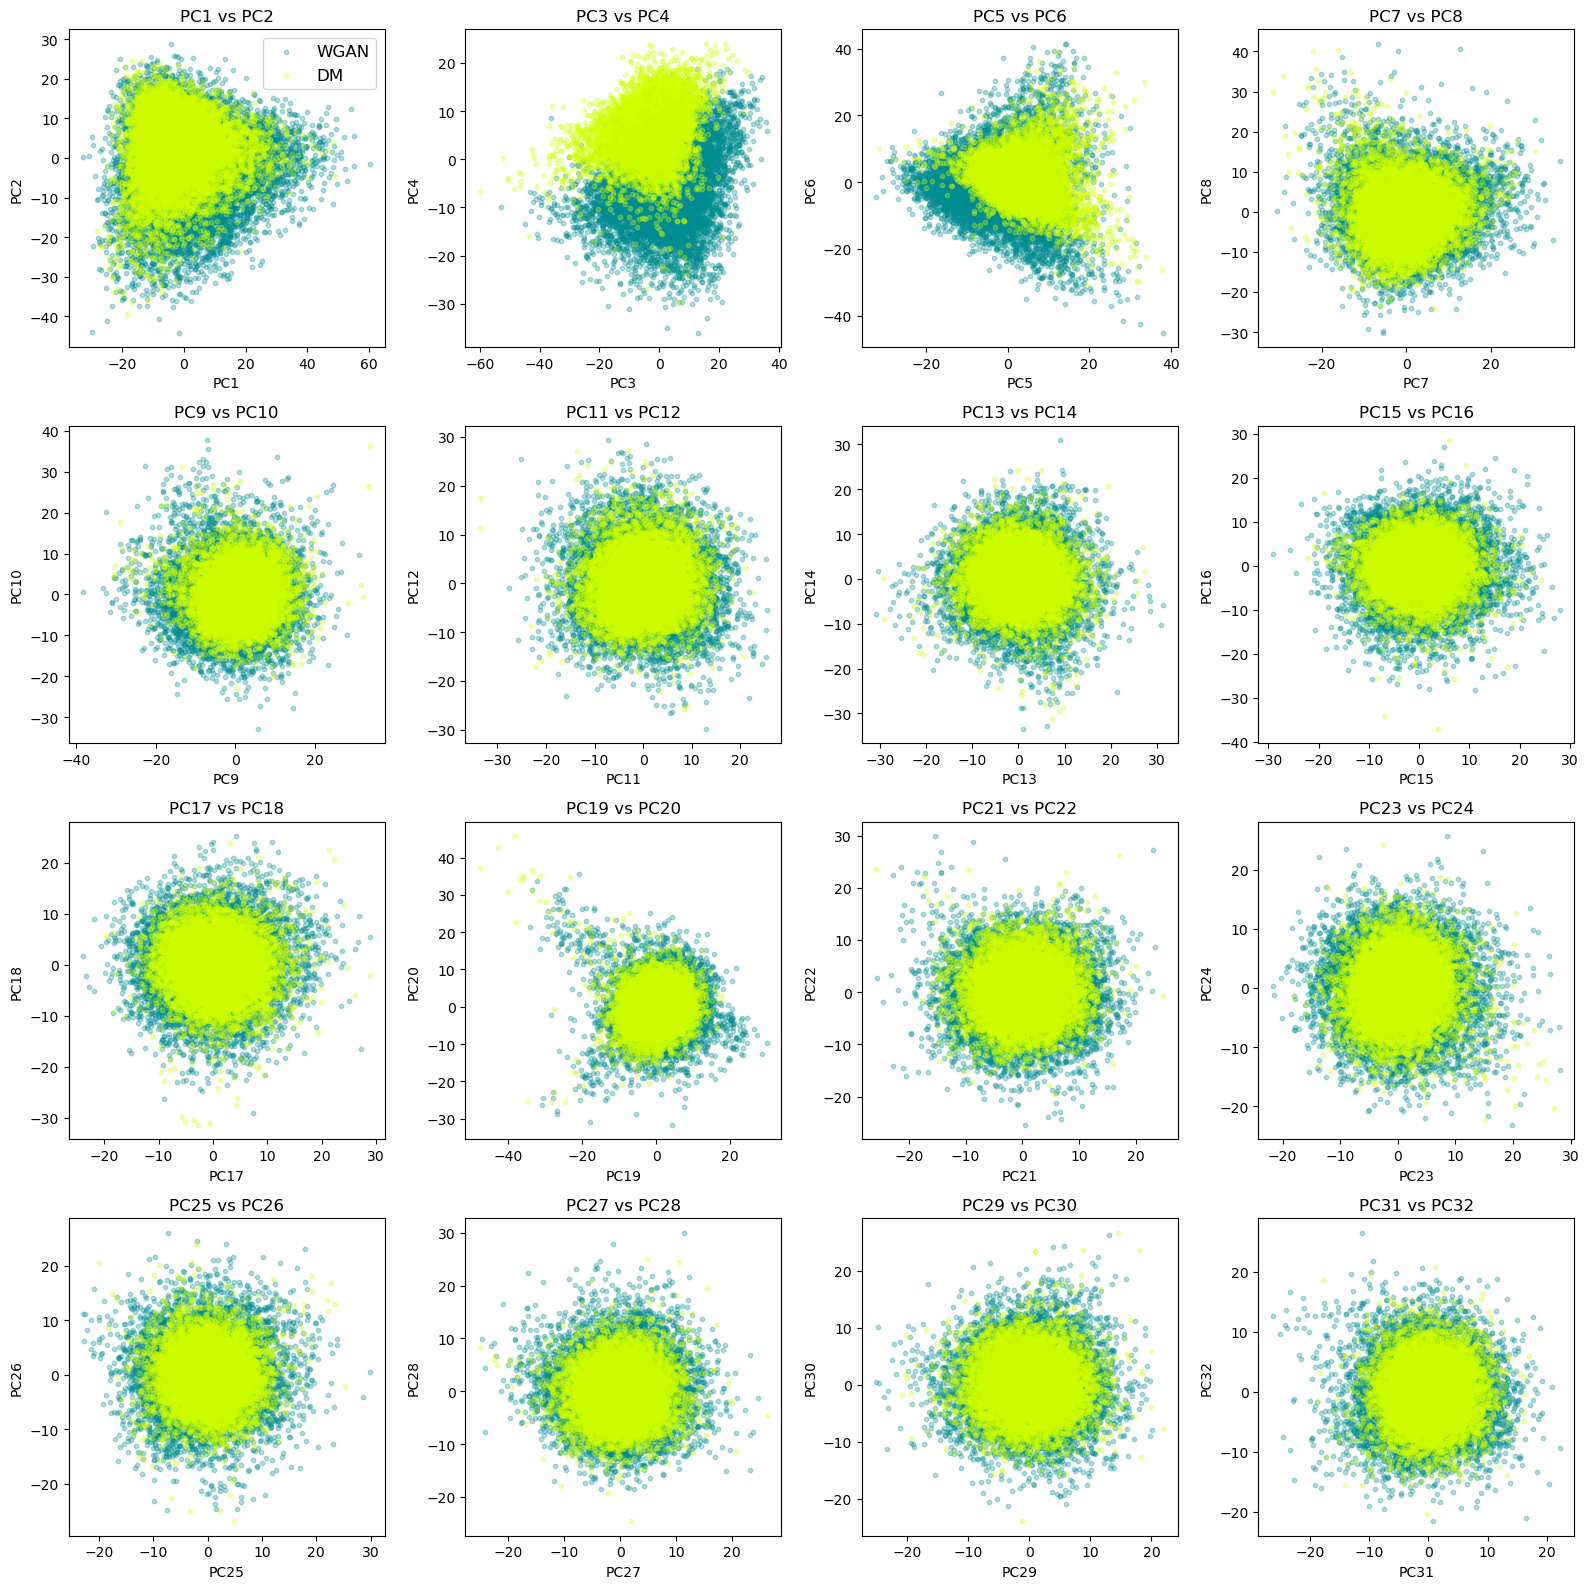

In [16]:
geno_PCA_32PC(WGAN_AGs[0],DM_AGs[0],'WGAN','DM',"PCA_32PC")

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


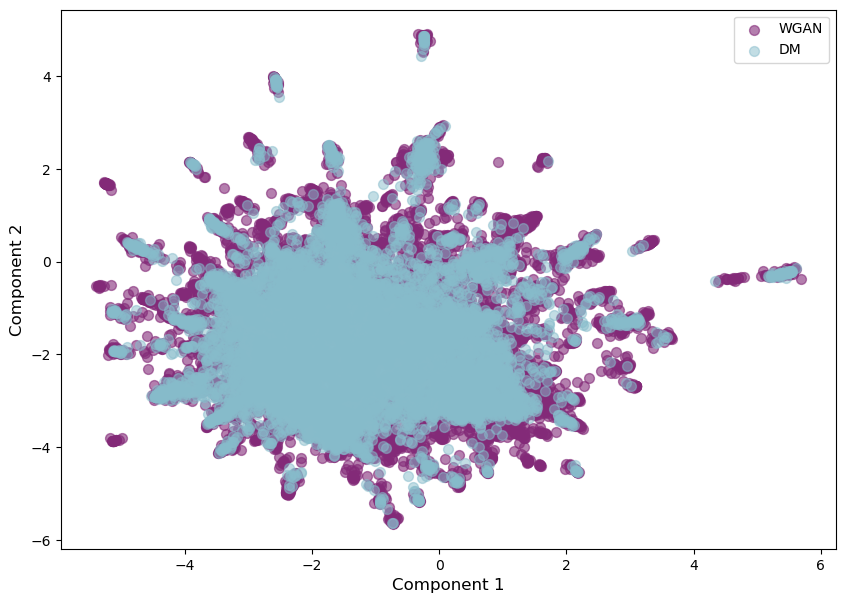

In [17]:
geno_UMAP(WGAN_AGs[0],DM_AGs[0],'WGAN','DM',"UMAP")

## Fixation Index

In [18]:
result_fst = []
for i in range(len(WGAN_AGs)):
    result_fst.append(aggregated_fst(WGAN_AGs[i], DM_AGs[i]))
average_metric = np.mean(result_fst)
precision = np.std(result_fst, ddof=1)  # ddof=1 for sample standard deviation
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.002136 ± 0.000015


## Precision and Recall

In [19]:
precisions,recalls, f1s = [],[],[]
for i in range(len(WGAN_AGs)):
    precision, recall = get_precision_recall(torch.tensor(WGAN_AGs[i].to_numpy()).to(dtype=torch.float32), torch.tensor(DM_AGs[i].to_numpy()).to(dtype=torch.float32), ks=[100], distance = "euclidean")
    f1_score = 2 * (precision * recall) / (precision + recall)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1_score)

Evaluated k-NN precision and recall in: 235.355s
Evaluated k-NN precision and recall in: 237.965s
Evaluated k-NN precision and recall in: 235.764s
Evaluated k-NN precision and recall in: 235.898s
Evaluated k-NN precision and recall in: 237.181s


In [20]:
# Precisions
average_metric = np.mean(precisions)
precision = np.std(precisions, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

1.000000 ± 0.000000


In [21]:
# Recalls
average_metric = np.mean(recalls)
precision = np.std(recalls, ddof=1) 
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.184760 ± 0.015455


In [22]:
# F1
average_metric = np.mean(f1s)
precision = np.std(f1s, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.311664 ± 0.022059


## Allele and Genotype Frequency

/home/jovyan/workspace/github_repo/DevDiscreteGenoGen/DiscreteGenoGen/demo/../metric/allele_freq.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'r--', color="#FF6F43", label='y = x (Ideal Match)')


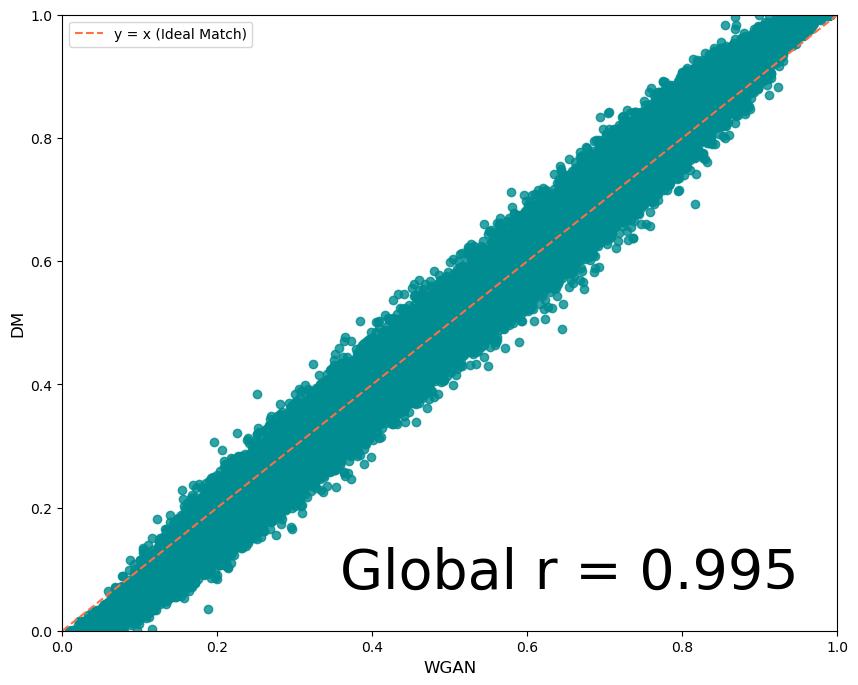

In [23]:
plot_allele_freq(WGAN_AGs[0],DM_AGs[0],'WGAN','DM',"allele_freq")

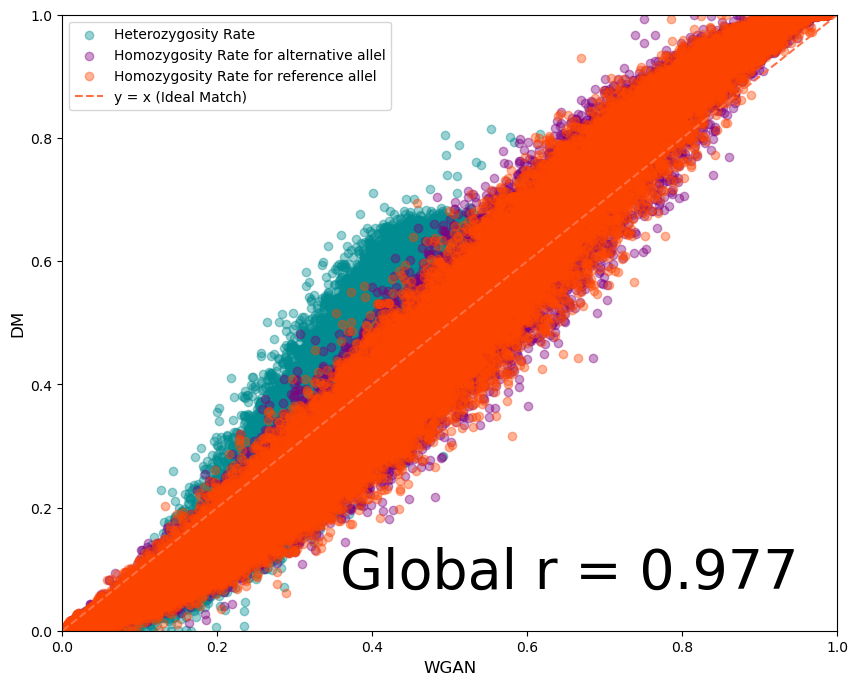

In [24]:
plot_geno_freq(WGAN_AGs[0],DM_AGs[0],'WGAN','DM',"geno_freq")

## Adversarial Accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


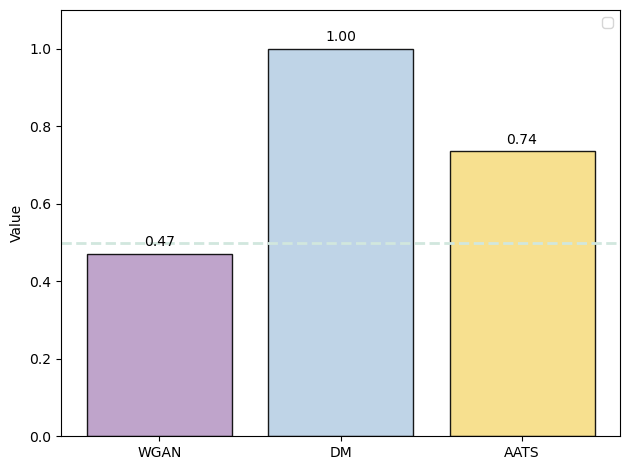

In [25]:
plot_aats(AATS(WGAN_AGs[0],DM_AGs[0], metric="euclidean"),'WGAN','DM',"AA")

## Correlation Score

In [26]:
result_corr = []
for i in range(len(WGAN_AGs)):
    result_corr.append(corr_score(WGAN_AGs[i],DM_AGs[i]))
average_metric = np.mean(result_corr)
precision = np.std(result_corr, ddof=1)
print("{:.6f} ± {:.6f}".format(average_metric, precision))

0.694454 ± 0.001207


## GWAS

In [27]:
cow_chr_dict = {1: 3121,
 2: 5672,
 3: 8190,
 4: 10499,
 5: 12737,
 6: 15324,
 7: 17415,
 8: 19557,
 9: 21475,
 10: 23459,
 11: 25593,
 12: 27121,
 13: 28784,
 14: 30555,
 15: 32188,
 16: 33761,
 17: 35241,
 18: 36945,
 19: 38489,
 20: 40229,
 21: 41612,
 22: 42804,
 23: 44072,
 24: 45251,
 25: 46238,
 26: 47349,
 27: 48216,
 28: 49107,
 29: 50161}

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Pearson correlation between Beta: 0.41668842556640706


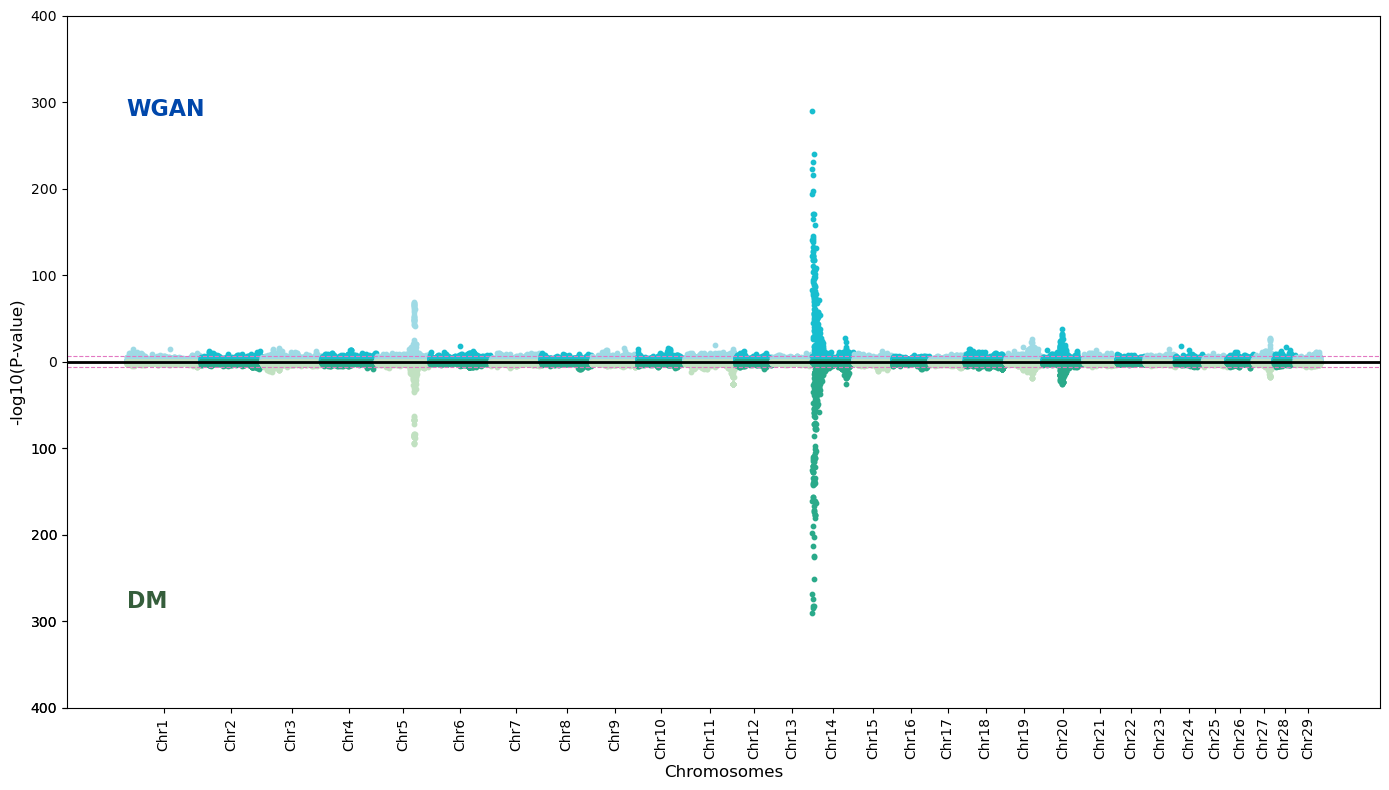

0.41668842556640706

In [28]:
plot_compare_gwas(WGAN_AGs[0], pheno, DM_AGs[0], pheno, cow_chr_dict, "WGAN","DM","GWAS")